<a href="https://colab.research.google.com/github/dagdag001/MNISTModel/blob/main/MNISTModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [203]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

#Device agnostic


In [204]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Loading MNIST dataset

In [205]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [206]:
class_names = training_data.classes

In [207]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

#Build the CNN model


In [208]:
class MNISTModelV0(nn.Module):
    def __init__(self, input_shape,
                 hidden_units,
                 output_shape):
      super().__init__()
      self.conv2D_block_1 = nn.Sequential (
          nn.Conv2d(in_channels = input_shape,
                    out_channels = hidden_units,
                    kernel_size = 2,
                    padding = 0,
                    stride = 1),
          nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                    out_channels = hidden_units,
                    kernel_size = 2,
                    padding = 0,
                    stride = 1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 2),
      )

      self.conv2D_block_2 = nn.Sequential (
          nn.Conv2d(in_channels = hidden_units,
                    out_channels = hidden_units,
                    kernel_size = 2,
                    padding = 0,
                    stride = 1),
          nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                    out_channels = hidden_units,
                    kernel_size = 2,
                    padding = 0,
                    stride = 1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 2),
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=hidden_units *5 * 5, out_features=output_shape)
      )

    def forward(self, x):
        x = self.conv2D_block_1(x)
        x = self.conv2D_block_2(x)
        x = self.classifier(x)
        return x



#Initialize model, loss function, and optimizer

In [209]:
model_0 = MNISTModelV0(input_shape=1,
                hidden_units=10,
                output_shape=len(class_names)).to(device)

In [210]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr= 0.1)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

#Training and Testing the Model


In [211]:
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} |\n---------")
    train_loss, train_acc  = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        model_0.train()
        y_preds = model_0(X)
        loss = loss_fn(y_preds, y)
        acc = accuracy_fn(y_true=y, y_pred=y_preds.argmax(dim=1))
        train_loss += loss.item()
        train_acc += acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_acc /= len(train_dataloader)
    train_loss /= len(train_dataloader)
    with torch.inference_mode():
        test_loss, test_acc  = 0, 0
        model_0.eval()
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            test_preds = model_0(X)
            loss = loss_fn(test_preds, y)
            acc = accuracy_fn(y_true=y, y_pred=test_preds.argmax(dim=1))
            test_loss += loss.item()
            test_acc += acc
        test_acc /= len(test_dataloader)
        test_loss /= len(test_dataloader)
    print(f"Train Loss: {train_loss:.2f} | Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 |
---------
Train Loss: 1.42 | Train Acc: 47.12%
Test Loss: 0.18986 | Test Acc: 94.24%
Epoch: 1 |
---------
Train Loss: 0.13 | Train Acc: 95.91%
Test Loss: 0.08603 | Test Acc: 97.32%
Epoch: 2 |
---------
Train Loss: 0.09 | Train Acc: 97.12%
Test Loss: 0.08244 | Test Acc: 97.25%


#Make predictions on test sample

In [212]:
def make_prediction(model, data, device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim= 0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [213]:
import random
# random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9 ):
  test_samples.append(sample)
  test_labels.append(label)
# plt.imshow(test_samples[0].squeeze(0), cmap="gray")

In [214]:
pred_probs = make_prediction(model_0, test_samples).argmax(dim=1)

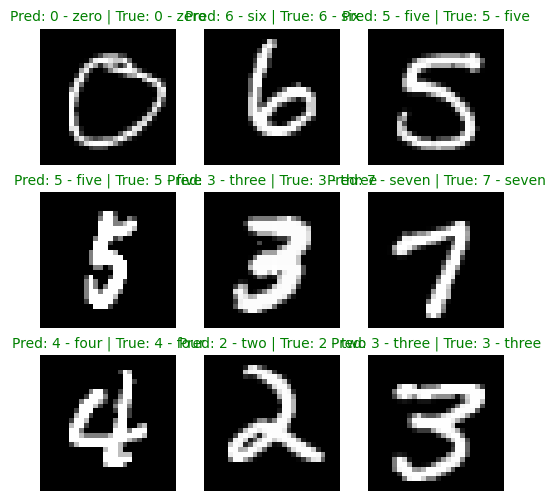

In [223]:
plt.figure(figsize=(6, 6))
for i, sample in enumerate( test_samples):
  plt.subplot(3, 3, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  truth_label = class_names[test_labels[i]]
  pred_label = class_names[pred_probs[i]]
  if truth_label == pred_label:
    plt.title(f"Pred: {class_names[pred_probs[i]]} | True: {class_names[test_labels[i]]}", fontsize=10, c='g')

  else:
    plt.title(f"Pred: {class_names[pred_probs[i]]} | True: {class_names[test_labels[i]]}",  fontsize=10, c='r')


  plt.axis(False)

# Create and plot the confusion matrix


In [216]:
y_preds = []
y_true = []

model_0.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X = X.to(device)
        y_logit = model_0(X)
        y_pred = y_logit.argmax(dim=1)
        y_preds.append(y_pred.cpu())
        y_true.append(y.cpu())

y_pred_tensor = torch.cat(y_preds)
y_true_tensor = torch.cat(y_true)


In [217]:
try:
  import torchmetrics, mlxtend
  print("torchmetrics already installed")
except:
  print("installing torchmetrics ")

  !pip install torchmetrics
  import torchmetrics, mlxtend


torchmetrics already installed


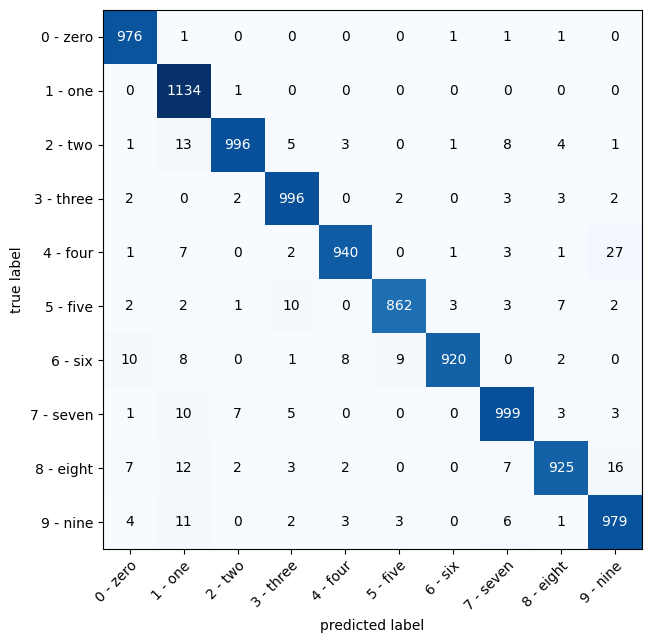

In [218]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

cm = ConfusionMatrix (num_classes = len(class_names), task="multiclass")
cm_tensor = cm(preds = y_pred_tensor, target =y_true_tensor)
cm_tensor

fig , ax = plot_confusion_matrix(cm_tensor.numpy(),
                                 class_names=class_names,
                                 figsize=(10, 7))


In [219]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "MNISTModel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

In [220]:
loded_model = MNISTModelV0(input_shape=1, hidden_units=10, output_shape=len(class_names))
loded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loded_model.to(device)

MNISTModelV0(
  (conv2D_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2D_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=250, out_features=10, bias=True)
  )
)